# Circle Detection - template matching
After a lot(!) of testing, it seems like template matching is the best method for detecting circles in our predicted targets. I.e. our template is a collection of cv2 circles with varying radii, and see if it matches any circles in the image.

In [2]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import match_template

import matplotlib.pyplot as plt
%matplotlib inline 

import utils.make_density_map_charles as mdm

In [3]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id

def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

In [4]:
dim, inv_color, rescale = 256, 1, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#reshape
train_data = train_data[:,:,:,0].reshape(len(train_data),256,256,1)
test_data = test_data[:,:,:,0].reshape(len(test_data),256,256,1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 3))
number of test files are: 240
('test shape:', (240, 256, 256, 3))


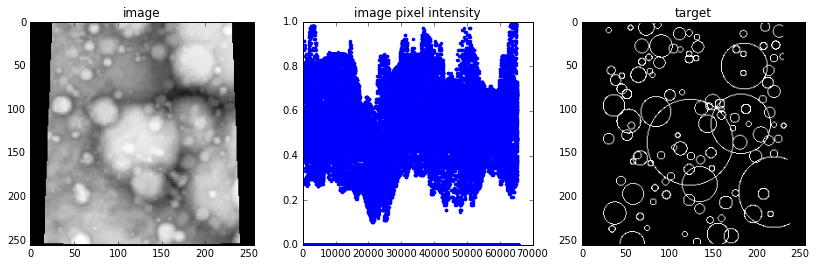

In [5]:
#images/target example
i=0
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 4])
ax1.imshow(train_data[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax1.set_title('image')
ax2.plot(train_data[i].reshape(dim*dim,1), '.')
ax2.set_title('image pixel intensity')
ax3.imshow(train_target[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax3.set_title('target')

## Try on real data - works well!

In [6]:
from keras.models import load_model
filename = 'models/unet_s256_rings_FL3_he_normal_customloss.h5'
model = load_model(filename)

Using TensorFlow backend.


In [7]:
n,off=3,3
target = model.predict(test_data[off:(n+off)].astype('float32'))

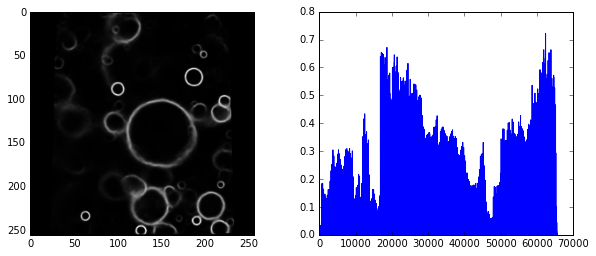

In [8]:
#predicted target + pixel intensities
i=0

f, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 4])
ax1.imshow(target[i], origin='upper', cmap="Greys_r")
ax2.plot(target[i].reshape(dim*dim))

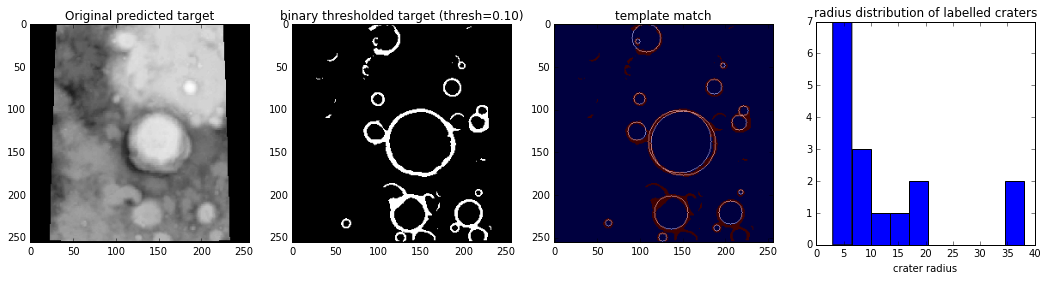

In [9]:
#template matching code
ring_thickness = 2       #thickness of rings for the templates. 2 seems to work well. 
template_thresh = 0.5    #0-1 range, if template matching probability > template_thresh, count as detection
image_thresh = 0.1       #0-1 range, pixel values > image_thresh -> 1, pixel values < image_thresh -> 0
duplicate_thresh2 = 20   #if (x1-x2)^2 + (y1-y2)^2 + (r1-r2)^2 < duplicate_thresh2, remove (x2,y2,r2) circle.

#image
img_i=0
img = target[img_i].copy()
img[img >= image_thresh] = 1
img[img < image_thresh] = 0

radii = np.linspace(3,50,45,dtype=int)
coords = []
for r in radii: 
    #template
    n = 2*(r+ring_thickness+1)
    template = np.zeros((n,n))
    cv2.circle(template, (r+ring_thickness+1,r+ring_thickness+1), r, 1, ring_thickness)

    #template match
    result = match_template(img, template, pad_input=True)
    coords_r = np.asarray(zip(*np.where(result > template_thresh)))
        
    #store x,y,r
    for c in coords_r:
        coords.append([c[1],c[0],r])
    
#remove duplicates at neighboring radii/locations
coords = np.asarray(coords)
i, N = 0, len(coords)
while i < N:
    diff = (coords - coords[i])**2
    diffsum = np.asarray([sum(x) for x in diff])
    index = (diffsum == 0)|(diffsum > duplicate_thresh2)
    coords = coords[index]
    N, i = len(coords), i+1    

# remove small false craters that arise because of thick edges
i, N = 0, len(coords)
dim = img.shape[0]
while i < N:
    x,y,r = coords[i]
    if r <= 6:   #this effect is not present for large craters
        mask = np.zeros((dim,dim))
        cv2.circle(mask, (x,y), int(np.round(r)), 1, thickness=-1)
        crater = img[mask==1]
        if np.sum(crater) == len(crater):   #crater is completely filled in, likely a false positive
            coords = np.delete(coords, i, axis=0)
            N = len(coords)
        else:
            i += 1
    else:
        i += 1
    
#plot circles and make radius distribution
mask = np.zeros((dim,dim))
radii_dist = []
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 1)
    radii_dist.append(r)

#plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=[18, 4])
ax1.imshow(test_data[img_i+off].reshape(dim,dim), origin='upper', cmap="Greys_r")
#ax1.imshow(target[img_i], origin='upper', cmap="Greys_r")
ax2.imshow(img, origin='upper', cmap="Greys_r")
ax3.imshow(img, origin='upper')
ax3.imshow(mask, origin='upper',alpha=0.5, cmap="Greys_r")
ax4.hist(radii_dist, 10)
ax1.set_title('Original predicted target')
ax2.set_title('binary thresholded target (thresh=%.2f)'%image_thresh)
ax3.set_title('template match')
ax4.set_title('radius distribution of labelled craters')
ax4.set_xlabel('crater radius')
plt.savefig("output_dir/images/template_match_%d.png"%img_i)

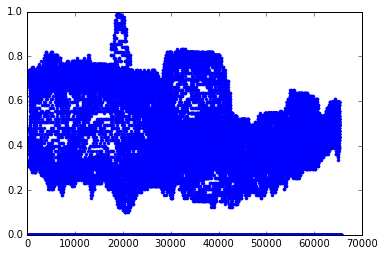

In [10]:
#this shows the match_template matching probabilities for a given radii 
#(since its a for loop this is showing you the final radii probabilities)
plt.plot(test_data[img_i+off].reshape(dim*dim),'.')

## template matching - FOR_CUSTOM_METRIC

In [11]:
def template_match_target_to_csv(target, csv_coords, minrad=2, maxrad=75):
    # hyperparameters, probably don't need to change
    ring_thickness = 2       #thickness of rings for the templates. 2 seems to work well.
    template_thresh = 0.5    #0-1 range, if template matching probability > template_thresh, count as detection
    target_thresh = 0.1      #0-1 range, pixel values > target_thresh -> 1, pixel values < target_thresh -> 0
    
    #Match Threshold (squared)
    # for template matching, if (x1-x2)^2 + (y1-y2)^2 + (r1-r2)^2 < match_thresh2, remove (x2,y2,r2) circle (it is a duplicate).
    # for predicted target -> csv matching, if (x1-x2)^2 + (y1-y2)^2 + (r1-r2)^2 < match_thresh2, positive detection
    match_thresh2 = 20
    
    # target - can be predicted or ground truth
    target[target >= target_thresh] = 1
    target[target < target_thresh] = 0

    radii = np.linspace(minrad,maxrad,maxrad-minrad,dtype=int)
    templ_coords = []        #coordinates extracted from template matching
    for r in radii:
        # template
        n = 2*(r+ring_thickness+1)
        template = np.zeros((n,n))
        cv2.circle(template, (r+ring_thickness+1,r+ring_thickness+1), r, 1, ring_thickness)
        
        # template match
        result = match_template(target, template, pad_input=True)   #skimage
        coords_r = np.asarray(zip(*np.where(result > template_thresh)))
        
        # store x,y,r
        for c in coords_r:
            templ_coords.append([c[1],c[0],r])
        
    # remove duplicates from template matching at neighboring radii/locations
    templ_coords = np.asarray(templ_coords)
    i, N = 0, len(templ_coords)
    while i < N:
        diff = (templ_coords - templ_coords[i])**2
        diffsum = np.asarray([sum(x) for x in diff])
        index = (diffsum == 0)|(diffsum > match_thresh2)
        templ_coords = templ_coords[index]
        N, i = len(templ_coords), i+1

    # remove small false craters that arise because of thick edges
    i, N = 0, len(coords)
    dim = target.shape[0]
    while i < N:
        x,y,r = coords[i]
        if r < 6:   #this effect is not present for large craters
            mask = np.zeros((dim,dim))
            cv2.circle(mask, (x,y), int(np.round(r)), 1, thickness=-1)
            crater = target[mask==1]
            if np.sum(crater) == len(crater):   #crater is completely filled in, likely a false positive
                coords = np.delete(coords, i)
                N = len(coords)
            else:
                i += 1
        else:
            i += 1
        
    # compare template-matched results to "ground truth" csv input data
    N_match = 0
    N_csv, N_templ = len(csv_coords), len(templ_coords)
    for tc in templ_coords:
        diff = (csv_coords - tc)**2
        diffsum = np.asarray([sum(x) for x in diff])
        index = (diffsum == 0)|(diffsum > match_thresh2)
        N = len(np.where(index==False)[0])
        if N > 1:
            print "multiple matches found in csv file for template matched crater ", tc, " :"
            print csv_coords[np.where(index==False)]
        N_match += N
        csv_coords = csv_coords[index]
        if len(csv_coords) == 0:
            #print "all matches found"
            break
    return N_match, N_csv, N_templ

#template matching - FOR_CUSTOM_METRIC
def prepare_custom_loss(path, dim, inv_color=1, rescale=1):
    # hyperparameters - should not change
    minrad, maxrad = 2, 75    #min/max radius (in pixels) required to include crater in target
    cutrad = 0.5              #0-1 range, if x+cutrad*r > img_width, remove, i.e. exclude craters ~half gone from image
    min_craters = 5           #minimum craters in the image required for processing (make it worth your while)
    
    # load data
    try:
        imgs = np.load("%s/custom_loss_images.npy"%path)
        csvs = np.load("%s/custom_loss_csvs.npy"%path)
        N_perfect_matches = len(imgs)
        print "Successfully loaded files locally for custom_loss."
    except:
        print "Couldn't load files for custom_loss, making now"
        imgs, targets, csvs = [], [], []
        csvs_ = glob.glob('%s/*.csv'%path)
        N_perfect_matches = 0
        for c in csvs_:
            print "processing file %s"%c
            csv = pd.read_csv(c)
            img = cv2.imread('%s.png'%c.split('.csv')[0], cv2.IMREAD_GRAYSCALE)/255.
            
            # prune csv list for small/large/half craters
            csv = csv[(csv['Diameter (pix)'] < 2*maxrad) & (csv['Diameter (pix)'] > 2*minrad)]
            csv = csv[(csv['x']+cutrad*csv['Diameter (pix)']/2 <= dim)]
            csv = csv[(csv['y']+cutrad*csv['Diameter (pix)']/2 <= dim)]
            csv = csv[(csv['x']-cutrad*csv['Diameter (pix)']/2 > 0)]
            csv = csv[(csv['y']-cutrad*csv['Diameter (pix)']/2 > 0)]
            if len(csv) < min_craters:
                print "only %d craters in image, skipping"%len(csv)
                continue
            
            # make target and csv array, ensure template matching algorithm is working - need Charles' ring routine
            target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=2, truncate=True)
            csv_coords = np.asarray((csv['x'],csv['y'],csv['Diameter (pix)']/2)).T
            N_match, N_csv, N_templ = template_match_target_to_csv(target, csv_coords, minrad, maxrad)
            if N_match == N_csv:
                imgs.append(img)
                targets.append(target)
                csvs.append(csv_coords)
                N_perfect_matches += 1
        imgs = np.array(imgs).astype('float32').reshape(len(imgs),dim,dim,1)
        targets = np.array(targets).astype('float32')
        #np.save("%s/custom_loss_images.npy"%path,imgs)
        #np.save("%s/custom_loss_csvs.npy"%path,csvs)
        print "out of %d files there are %d perfect matches"%(len(csvs_),N_perfect_matches)
    return imgs, csvs, N_perfect_matches

In [12]:
path, dim = 'datasets/rings/Dev_rings_for_loss/', 256
imgs, csvs, N_perfect_matches = prepare_custom_loss(path, dim)

Successfully loaded files locally for custom_loss.


In [13]:
#Now test on real data
from keras.models import load_model
filename = 'models/unet_s256_rings_FL3_he_normal_customloss.h5'
model = load_model(filename)

In [14]:
target = model.predict(imgs[0:2].astype('float32'))

In [15]:
N_match, N_csv, N_templ = template_match_target_to_csv(target[0], csvs[0])
print N_match, N_csv, N_templ

UnboundLocalError: local variable 'coords' referenced before assignment

### Debuging

In [ ]:
#TEST - debugging

ring_thickness = 2       #thickness of rings for the templates. 2 seems to work well. 
template_thresh = 0.5    #0-1 range, if template matching probability > template_thresh, count as detection
image_thresh = 0.1       #0-1 range, pixel values > image_thresh -> 1, pixel values < image_thresh -> 0
duplicate_thresh2 = 20   #if (x1-x2)^2 + (y1-y2)^2 + (r1-r2)^2 < duplicate_thresh2, remove (x2,y2,r2) circle.

#image
path = 'datasets/rings/Test_rings_for_custom_loss/lola_22515.csv'
img = cv2.imread('%s.png'%path.split('.csv')[0], cv2.IMREAD_GRAYSCALE)/255.
csv = pd.read_csv(path)
csv = csv[(csv['Diameter (pix)'] < 2*maxrad) & (csv['Diameter (pix)'] > 2*minrad)]
target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=2, truncate=True)

radii = np.linspace(3,50,45,dtype=int)
coords = []
for r in radii: 
    #template
    n = 2*(r+ring_thickness+1)
    template = np.zeros((n,n))
    cv2.circle(template, (r+ring_thickness+1,r+ring_thickness+1), r, 1, ring_thickness)

    #template match
    result = match_template(target, template, pad_input=True)
    coords_r = np.asarray(zip(*np.where(result > template_thresh)))
        
    #store x,y,r
    for c in coords_r:
        coords.append([c[1],c[0],r])
    
#remove duplicates at neighboring radii/locations
coords = np.asarray(coords)
i, N = 0, len(coords)
while i < N:
    diff = (coords - coords[i])**2
    diffsum = np.asarray([sum(x) for x in diff])
    index = (diffsum == 0)|(diffsum > duplicate_thresh2)
    coords = coords[index]
    N, i = len(coords), i+1

#plot circles and make radius distribution
mask = np.zeros((dim,dim))
radii_dist = []
coords = [(97.51582267,178.52755143,12.10243522),(98.16887441,178.24357505,12.49393497)]
for c in coords:
    x,y,r = c
    cv2.circle(mask, (int(x),int(y)), int(r), 1, 2)
    radii_dist.append(r)

#plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=[18, 4])
ax1.imshow(img, origin='upper', cmap="Greys_r")
ax2.imshow(target, origin='upper', cmap="Greys_r")
ax3.imshow(target, origin='upper')
ax3.imshow(mask, origin='upper',alpha=0.5, cmap="Greys_r")
ax4.hist(radii_dist, 10)
ax1.set_title('Original predicted target')
ax2.set_title('binary thresholded target (thresh=%.2f)'%image_thresh)
ax3.set_title('template match')
ax4.set_title('radius distribution of labelled craters')
ax4.set_xlabel('crater radius')
plt.savefig("output_dir/images/template_match_%d.png"%img_i)

## Recognize Artificial Circles, for testing

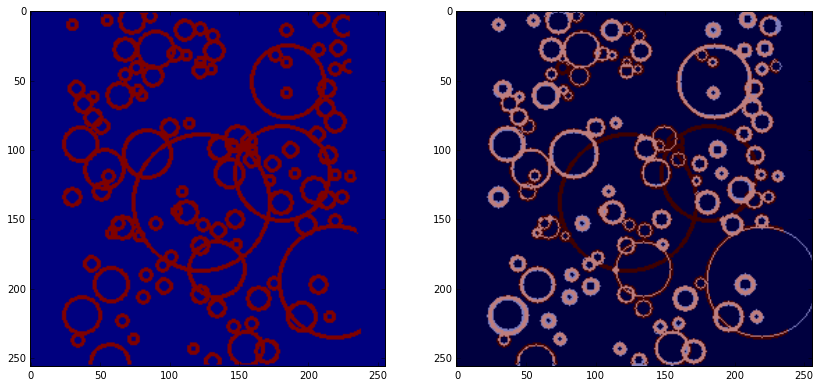

In [148]:
from skimage.feature import match_template
thickness = 2
thresh = 0.5

#image
i=0
img = train_target[i]

radii = np.linspace(1,50,50,dtype=int)
mask = np.zeros((dim,dim))
for r in radii: 
    #template
    n = 2*(r+thickness+1)
    template = np.zeros((n,n))
    cv2.circle(template, (r+thickness+1,r+thickness+1), r, 1, thickness)

    #template match
    result = match_template(img, template, pad_input=True)
    y, x, = np.where(result > thresh)

    #fill in matches
    for i in range(len(x)):
        cv2.circle(mask, (x[i],y[i]), r, 1, 1)

f, (ax1, ax2) = plt.subplots(1,2, figsize=[14, 8])
ax1.imshow(img, origin='upper')
ax2.imshow(img, origin='upper')
ax2.imshow(mask, origin='upper',alpha=0.5, cmap="Greys_r")

## old contour detection pipeline
This was my previous best, but it only worked on ground truth targets, vs. neural network predictions.

Some useful links:  
https://stackoverflow.com/questions/13070075/how-to-detect-circles-accurately  
http://opencvpython.blogspot.ca/2012/06/contours-2-brotherhood.html  
https://stackoverflow.com/questions/32287032/circular-hough-transform-misses-circles  
http://layer0.authentise.com/detecting-circular-shapes-using-contours.html  

Numpy/OpenCV formatting/processing links:  
https://stackoverflow.com/questions/7587490/converting-numpy-array-to-opencv-array  
https://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array  

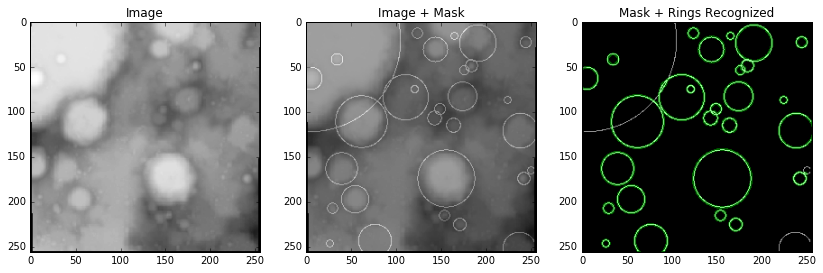

In [16]:
img_i=26
t = test_target[img_i].copy()
t = t.astype(np.uint8)                      #findcontours and Canny only take uint8. 
imgshape = t.shape[0]

#hyperparameters
thresh = 3         #2-3 seems to work well
mask_thickness = 2

center, radius = [], []
cimg = cv2.cvtColor(t, cv2.COLOR_GRAY2BGR) 
image, contours, hierarchy = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    (x,y),r = cv2.minEnclosingCircle(cnt)
    x,y,r = int(x), int(y), int(r)
    #x,y,r = int(round(x)), int(round(y)), int(round(r))          #center/radius of circle
    yy,xx = np.ogrid[-y:imgshape-y, -x:imgshape-x]               #locate centroid of ring in image
    mask_ring = np.abs(yy*yy + xx*xx - r*r)/r <= mask_thickness  #create a ring mask
    if np.abs(np.sum(t[mask_ring]) - 2*np.pi*r)/r < thresh:      #check if ring mask corresponds to real ring in image
        cv2.circle(cimg,(x,y),r,(0,255,0),thickness=2)           #draw circle
        center.append((x,y)); radius.append(r)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 8])
ax1.imshow(test_data[img_i].reshape(dim,dim), cmap="Greys_r")
ax1.set_title("Image")
ax2.imshow(test_data[img_i].reshape(dim,dim), cmap="Greys_r")
ax2.imshow(test_target[img_i], origin='upper', cmap="Greys_r",alpha=0.3)
ax2.set_title("Image + Mask")
ax3.imshow(test_target[img_i], origin='upper', cmap="Greys_r")
ax3.imshow(cimg, origin='upper', cmap="Greys_r",alpha=0.4)
ax3.set_title("Mask + Rings Recognized")
plt.savefig("output_dir/images/Hough_%d.png"%img_i)

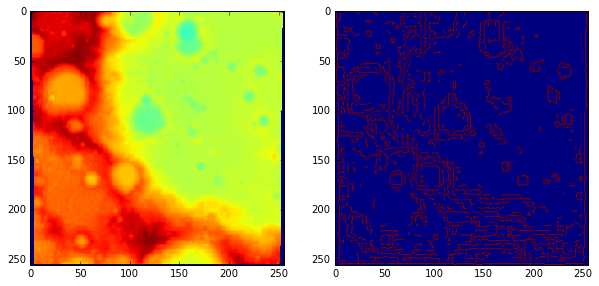

In [85]:
#simple edge detection on images - sucks!
f, (ax1, ax2) = plt.subplots(1,2, figsize=[10, 8])

t = cv2.imread("datasets/rings/Test_rings/lola_22511.png",0)
edge_detected_image = cv2.Canny(t, 20, 15)
ax1.imshow(t)
ax2.imshow(edge_detected_image)

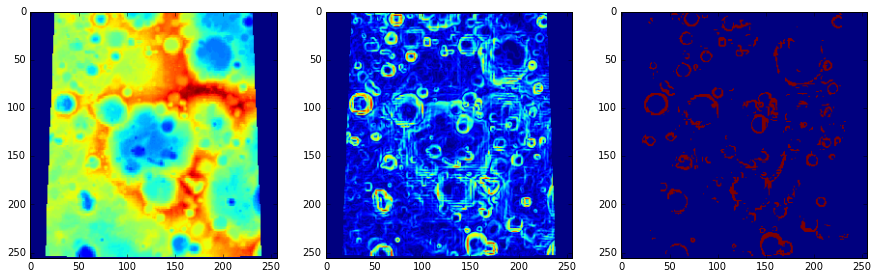

In [11]:
#try sobel detection - works better...
from skimage import filters, io
i=0
image = train_data[i].reshape(dim,dim)
mask = np.zeros((dim,dim))
mask[image > 0] = 1
sobel = filters.sobel(image, mask=mask);
roberts = filters.roberts(image, mask=mask)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 8])
ax1.imshow(image)
ax2.imshow(sobel)

conv = sobel*train_target[i]
thresh = 0.05
conv[conv<thresh] = 0
conv[conv>=thresh] = 1
ax3.imshow(conv)

In [83]:
x,y,r=100,100,3
a = np.zeros((256,256))
cv2.circle(a, (x,y), int(np.round(r)), 1, thickness=-1)
b = np.ones((256,256))
#b[x,y] = 0
if np.sum(b[a == 1]) == len(b[a==1]):
    print "hi"

hi


0.990297423683


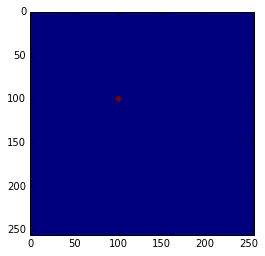

In [72]:
plt.imshow(a); print np.sum(b[a == 1])/(np.pi*r**2)